### Fuzzy Control Systems: Advanced Example
The tipping problem is a classic, simple example. If you’re new to this, start with the Fuzzy Control Primer and move on to the tipping problem.

This example assumes you’re familiar with those topics. Go on. We’ll wait.

### Typical Fuzzy Control System
Many fuzzy control systems are tasked to keep a certain variable close to a specific value. For instance, the temperature for an industrial chemical process might need to be kept relatively constant. In order to do this, the system usually knows two things:

- The error, or deviation from the ideal value
- The way the error is changing. This is the mathematical first derivative; we’ll call it delta

From these two values we can construct a system which will act appropriately.

Set up the Fuzzy Control System
We’ll use the new control system API for this problem. It would be far too complicated to model manually!

In [1]:
import numpy as np
import skfuzzy.control as ctrl

# Sparse universe makes calculations faster, without sacrifice accuracy.
# Only the critical points are included here; making it higher resolution is
# unnecessary.
universe = np.linspace(-2, 2, 5)

# Create the three fuzzy variables - two inputs, one output
error = ctrl.Antecedent(universe, 'error')
delta = ctrl.Antecedent(universe, 'delta')
output = ctrl.Consequent(universe, 'output')

# Here we use the convenience `automf` to populate the fuzzy variables with
# terms. The optional kwarg `names=` lets us specify the names of our Terms.
names = ['nb', 'ns', 'ze', 'ps', 'pb']
error.automf(names=names)
delta.automf(names=names)
output.automf(names=names)

Define complex rules

This system has a complicated, fully connected set of rules defined below.

In [2]:
rule0 = ctrl.Rule(antecedent=((error['nb'] & delta['nb']) |
                              (error['ns'] & delta['nb']) |
                              (error['nb'] & delta['ns'])),
                  consequent=output['nb'], label='rule nb')

rule1 = ctrl.Rule(antecedent=((error['nb'] & delta['ze']) |
                              (error['nb'] & delta['ps']) |
                              (error['ns'] & delta['ns']) |
                              (error['ns'] & delta['ze']) |
                              (error['ze'] & delta['ns']) |
                              (error['ze'] & delta['nb']) |
                              (error['ps'] & delta['nb'])),
                  consequent=output['ns'], label='rule ns')

rule2 = ctrl.Rule(antecedent=((error['nb'] & delta['pb']) |
                              (error['ns'] & delta['ps']) |
                              (error['ze'] & delta['ze']) |
                              (error['ps'] & delta['ns']) |
                              (error['pb'] & delta['nb'])),
                  consequent=output['ze'], label='rule ze')

rule3 = ctrl.Rule(antecedent=((error['ns'] & delta['pb']) |
                              (error['ze'] & delta['pb']) |
                              (error['ze'] & delta['ps']) |
                              (error['ps'] & delta['ps']) |
                              (error['ps'] & delta['ze']) |
                              (error['pb'] & delta['ze']) |
                              (error['pb'] & delta['ns'])),
                  consequent=output['ps'], label='rule ps')

rule4 = ctrl.Rule(antecedent=((error['ps'] & delta['pb']) |
                              (error['pb'] & delta['pb']) |
                              (error['pb'] & delta['ps'])),
                  consequent=output['pb'], label='rule pb')

Despite the lengthy ruleset, the new fuzzy control system framework will execute in milliseconds. 

Next we add these rules to a new ControlSystem and define a ControlSystemSimulation to run it.

In [3]:
system = ctrl.ControlSystem(rules=[rule0, rule1, rule2, rule3, rule4])

# Later we intend to run this system with a 21*21 set of inputs, so we allow
# that many plus one unique runs before results are flushed.
# Subsequent runs would return in 1/8 the time!
sim = ctrl.ControlSystemSimulation(system, flush_after_run=21 * 21 + 1)

### View the control space
With helpful use of Matplotlib and repeated simulations, we can observe what the entire control system surface looks like in three dimensions!

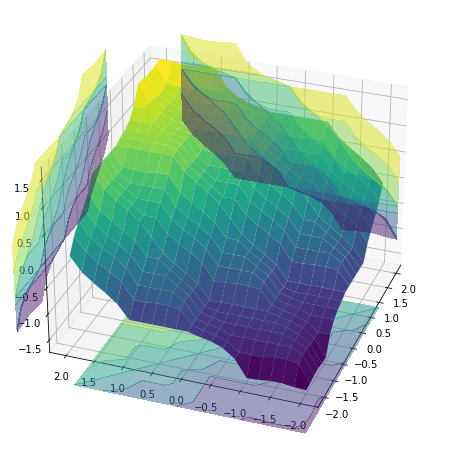

In [4]:
# We can simulate at higher resolution with full accuracy
upsampled = np.linspace(-2, 2, 21)
x, y = np.meshgrid(upsampled, upsampled)
z = np.zeros_like(x)

# Loop through the system 21*21 times to collect the control surface
for i in range(21):
    for j in range(21):
        sim.input['error'] = x[i, j]
        sim.input['delta'] = y[i, j]
        sim.compute()
        z[i, j] = sim.output['output']

# Plot the result in pretty 3D with alpha blending
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

cset = ax.contourf(x, y, z, zdir='z', offset=-2.5, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='y', offset=3, cmap='viridis', alpha=0.5)

ax.view_init(30, 200)

### Final thoughts
This example used a number of new, advanced techniques which may be helpful in practical fuzzy system design:

- A highly sparse (maximally sparse) system
- Controll of Term names generated by automf
- A long and logically complicated ruleset, with order-of-operations respected
- Control of the cache flushing on creation of a ControlSystemSimulation, which can be tuned as needed depending on memory constraints
- Repeated runs of a ControlSystemSimulation
- Creating and viewing a control surface in 3D.

Python source code: download (generated using skimage 0.2)